In [1]:
%matplotlib inline

import os
import random
    
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

if "model" in os.getcwd():
    os.chdir('..')
    
import predictions

from model.models import GLMModel, load_input, RandomForestModel
from model.preprocess import DataManager

In [2]:
training = predictions.read_training('data/retail-tract-training-data.csv')
testing = predictions.read_testing_data('data/retail-tract-testing-data.csv')
manager = DataManager()
model = GLMModel()

X, y, X_test = predictions.prepare_data(training, testing, manager)

In [3]:
from sklearn.model_selection import KFold

def produce_preds(insample=False, nfolds=10):
    if insample:
        model.fit(y, X)
        preds = model.predict(X)[:, 0]
        residuals = preds - y['initial_customers']
        return preds, residuals
        
    all_preds = None
    all_residuals = None
        
    kf = KFold(n_splits=nfolds)
    for train, test in kf.split(X):
        Xt, yt = X.iloc[train, :], y.iloc[train, :]
        Xtest, ytest = X.iloc[test, :], y.iloc[test, :]
        
        model.fit(yt, Xt)
        preds = model.predict(Xtest)[:, 0]
        residuals = preds - ytest['initial_customers']
        
        if all_preds is None:
            all_preds = preds
        else:
            all_preds = np.concatenate((all_preds, preds), axis=0)
        
        all_residuals = pd.concat((all_residuals, residuals), axis=0)
        
    return all_preds, all_residuals

preds, residuals = produce_preds(insample=False, nfolds=5)

In [4]:
import seaborn as sns

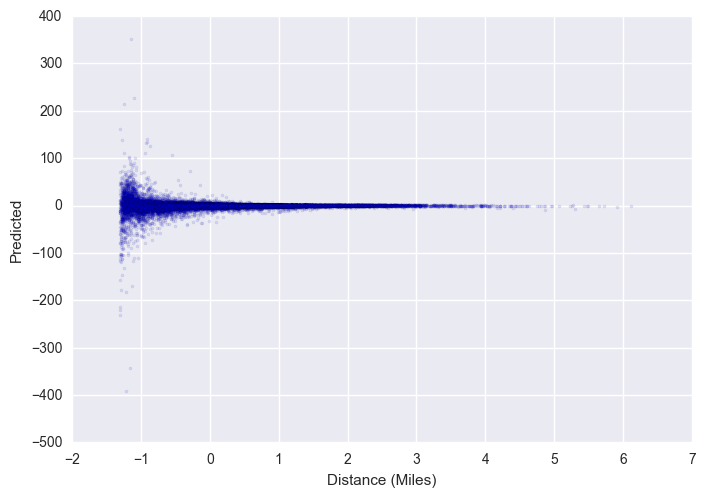

In [5]:
# Predictions vs. Distance
plt.scatter(X['dist_to_store_mi'], residuals, s=5, alpha=.1)
plt.xlabel("Distance (Miles)")
plt.ylabel("Predicted")

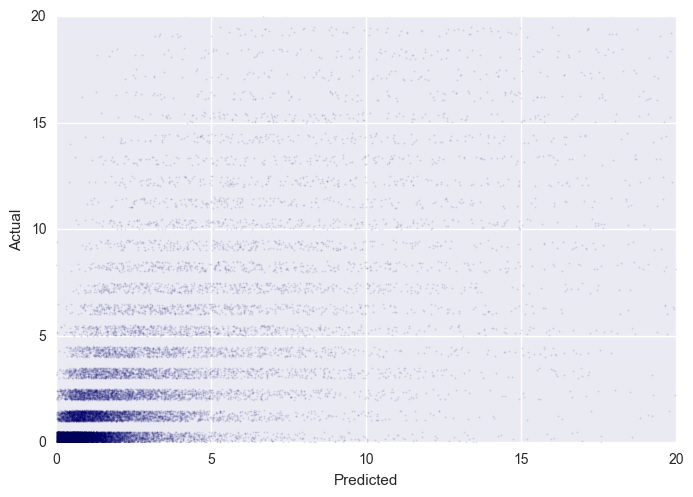

In [6]:
# scatter plot of expected vs actual: with and without quantiles
plt.scatter(preds, y['initial_customers'] +
                   np.random.random(size=len(y['initial_customers']))*.5, s=1, alpha=.1)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel("Predicted")
plt.ylabel("Actual")

0.700     4.0
0.727     4.0
0.754     5.0
0.781     6.0
0.808     7.0
0.835     8.0
0.862    10.0
0.889    13.0
0.916    18.0
0.943    26.0
0.970    43.0
Name: initial_customers, dtype: float64 

[  3.81812503   4.31507112   4.95613826   5.73132002   6.65913754
   7.9558373    9.65534832  12.16792117  16.02849828  24.04735456
  41.39958648] 



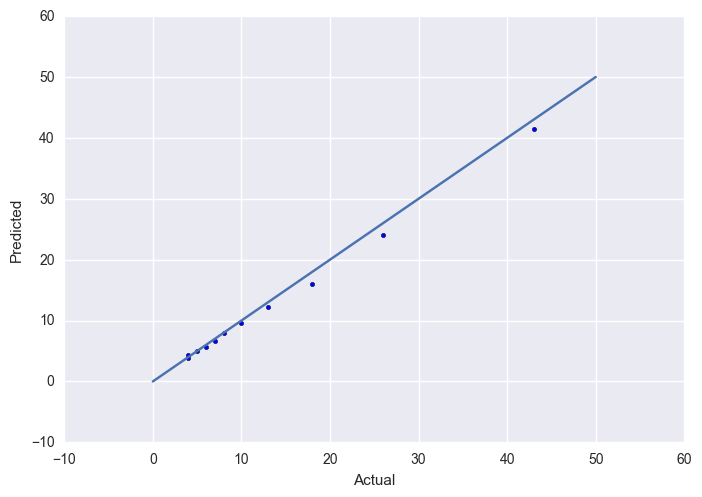

In [7]:
quantiles = np.linspace(0.7, 0.97, 11)
print(y['initial_customers'].quantile(quantiles), '\n')
print(np.percentile(preds, quantiles*100), '\n')
# scatter plot with percentiles
plt.scatter(y['initial_customers'].quantile(quantiles), np.percentile(preds, quantiles*100), s=10)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([0, 50], [0, 50])

In [8]:
# Taking out the areas with 0 actual buyers
np.mean(np.abs(residuals[y['initial_customers'] != 0]))

5.455244491755809

In [9]:
# What if we considered the model a classifier?
n = 1
def labeler(row):
    if row.expected > n and row.actual > n:
        return "True Positive"
    elif row.expected > n and row.actual <= n:
        return "False Positive"
    elif row.expected <= n and row.actual > n:
        return "False Negative"
    elif row.expected <= n and row.actual <= n:
        return "True Negative"
    
df = (pd.DataFrame(y['initial_customers'])
        .rename(columns={'initial_customers': 'actual'}))
df['expected'] = preds
results = df.apply(labeler, axis=1).value_counts() / len(df)

In [10]:
precision = results['True Positive'] / (results['True Positive'] + results['False Positive'])
recall = results['True Positive'] / (results['True Positive'] + results.get('False Negative', 0))
f1score = 2 * precision * recall / (precision + recall)
print("Precision: {:%} \nRecall: {:%} \nF1 Score: {}".format(precision, recall, f1score))

Precision: 62.915616% 
Recall: 91.634615% 
F1 Score: 0.7460678955234502


## Where are the errors coming from?

Are lots of little errors being summed up, or are they bigger in certain areas of the metro?

In [11]:
df_training = df.join(training)
df_training['residuals'] = df_training['actual'] - df_training['expected']
df_training['pe'] = df_training['residuals'] / df_training['actual']
df_training['dist_round'] = df_training['dist_to_store_mi'].map(lambda x: min(np.round(x), 50))

print('NEGATIVE MEANS WE OVERPREDICT')

for mi_cutoff in range(1, 20):
    df_training['close'] = (df_training['dist_to_store_mi'] <= mi_cutoff).astype(int)
    c = df_training.groupby('close')['residuals'].mean().to_dict()
    print('For mi cutoff {}: {:.3f} vs. {:.3f} (far, close) - close is {:.2f}% worse'.format(
            mi_cutoff, c[0], c[1], (c[1] / c[0]) * 100))
    
print('*******************************************')

for mi_cutoff in range(1, 20):
    df_training['close'] = (df_training['dist_to_store_mi'] <= mi_cutoff).astype(int)
    c = df_training[df_training['actual'] > 0].groupby('close')['pe'].mean().to_dict()
    print('For mi cutoff {}: {:.3f} vs. {:.3f} (far, close) - close is {:.2f}% worse'.format(
            mi_cutoff, c[0], c[1], (c[1] / c[0]) * 100))

NEGATIVE MEANS WE OVERPREDICT
For mi cutoff 1: -0.179 vs. 20.826 (far, close) - close is -11639.91% worse
For mi cutoff 2: -0.199 vs. 5.796 (far, close) - close is -2910.74% worse
For mi cutoff 3: -0.075 vs. 0.475 (far, close) - close is -634.35% worse
For mi cutoff 4: 0.040 vs. -1.011 (far, close) - close is -2544.59% worse
For mi cutoff 5: 0.013 vs. -0.508 (far, close) - close is -3878.47% worse
For mi cutoff 6: -0.064 vs. 0.052 (far, close) - close is -81.53% worse
For mi cutoff 7: -0.033 vs. -0.107 (far, close) - close is 327.01% worse
For mi cutoff 8: -0.031 vs. -0.100 (far, close) - close is 322.92% worse
For mi cutoff 9: -0.056 vs. -0.021 (far, close) - close is 37.30% worse
For mi cutoff 10: -0.096 vs. 0.069 (far, close) - close is -72.25% worse
For mi cutoff 11: -0.103 vs. 0.065 (far, close) - close is -63.11% worse
For mi cutoff 12: -0.101 vs. 0.044 (far, close) - close is -44.15% worse
For mi cutoff 13: -0.088 vs. 0.013 (far, close) - close is -15.34% worse
For mi cutoff 14:

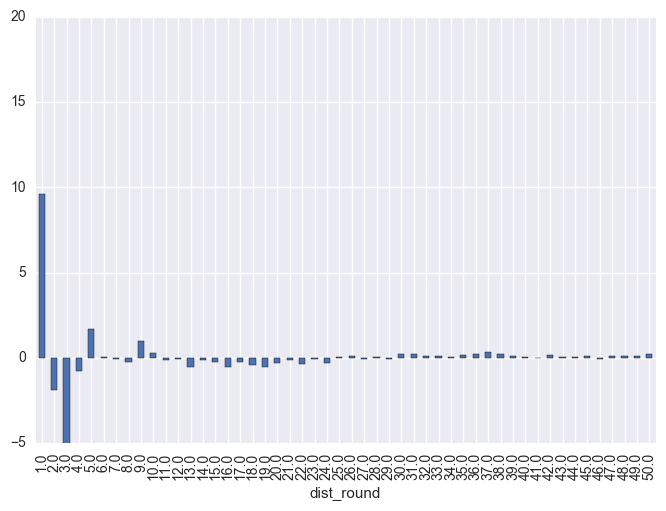

In [12]:
df_training.groupby('dist_round')['residuals'].mean().plot(kind='bar', ylim=(-5, 20))

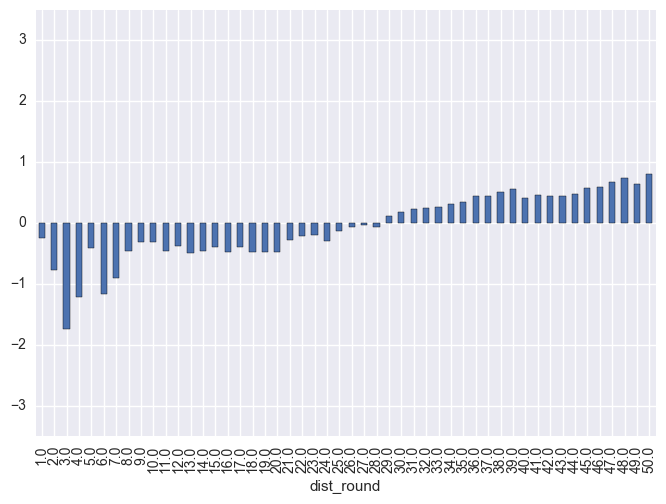

In [13]:
df_training[df_training['actual'] > 0].groupby('dist_round')['pe'].mean().plot(kind='bar', ylim=(-3.5, 3.5))

In [14]:
cbsa_pops = X.reset_index().groupby('cbsa_name')['pop2015'].sum()
err_by_city = pd.DataFrame(residuals.groupby(level='cbsa_name').mean().sort_values())
err_by_city['cbsa_pop'] = cbsa_pops

from scipy import stats
stats.pearsonr(err_by_city['initial_customers'], np.log(err_by_city['cbsa_pop']))

(-0.15538590191784141, 0.5381080007478225)

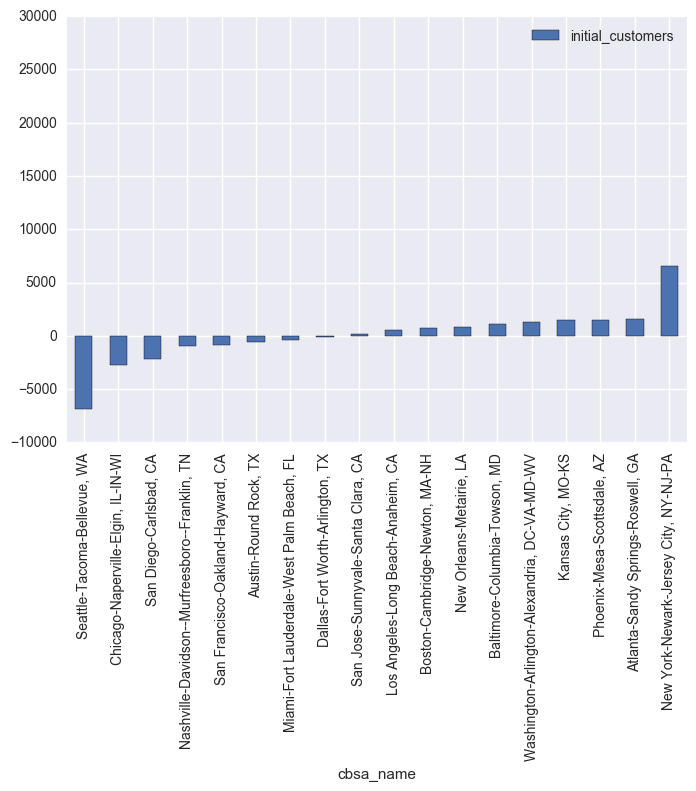

In [15]:
total_err_by_city = pd.DataFrame(residuals.groupby(level='cbsa_name').sum().sort_values())
total_err_by_city.plot(kind='bar', ylim=(-10000, 30000))

Negative means UNDERpredicting


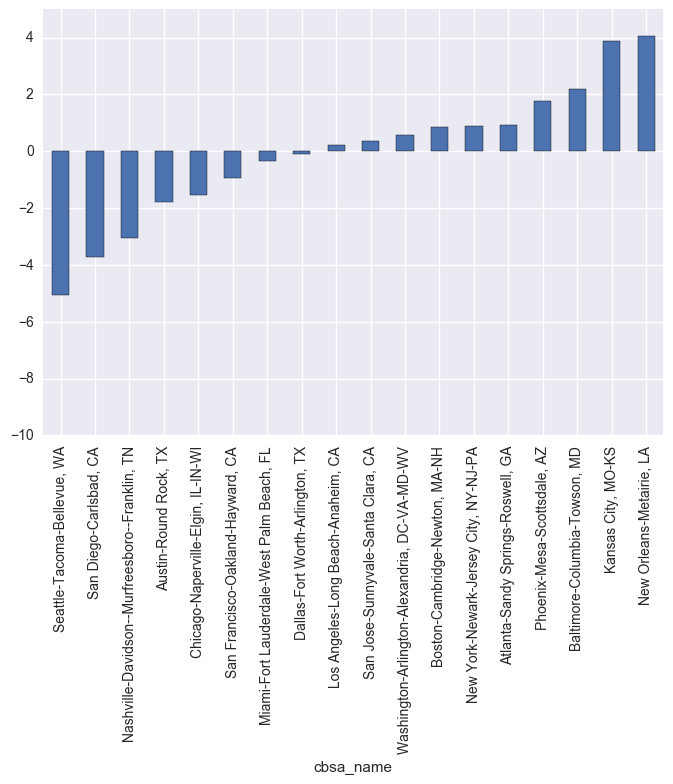

In [16]:
print('Negative means UNDERpredicting')
err_by_city['initial_customers'].plot(kind='bar', ylim=(-10, 5))

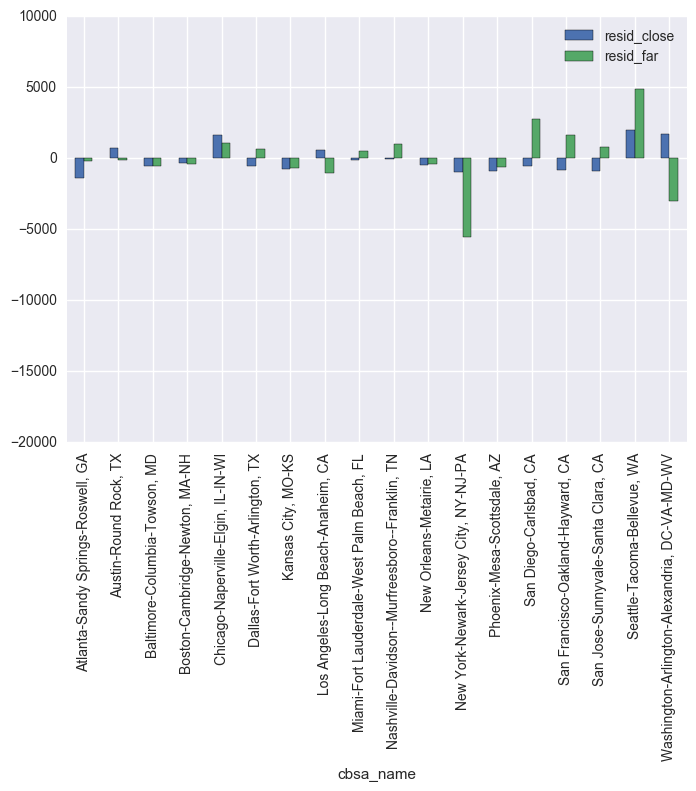

In [17]:
cbsa_close_far = (df_training.assign(dist_close = lambda x: x['dist_round'] <= 4)
                             .assign(resid_close = lambda x: x['residuals'] * x['dist_close'],
                                     resid_far = lambda x: x['residuals'] * (~x['dist_close']))
                             .groupby(level='cbsa_name').sum()[['resid_close', 'resid_far']])
cbsa_close_far.plot(kind='bar', ylim=(-20000, 10000))

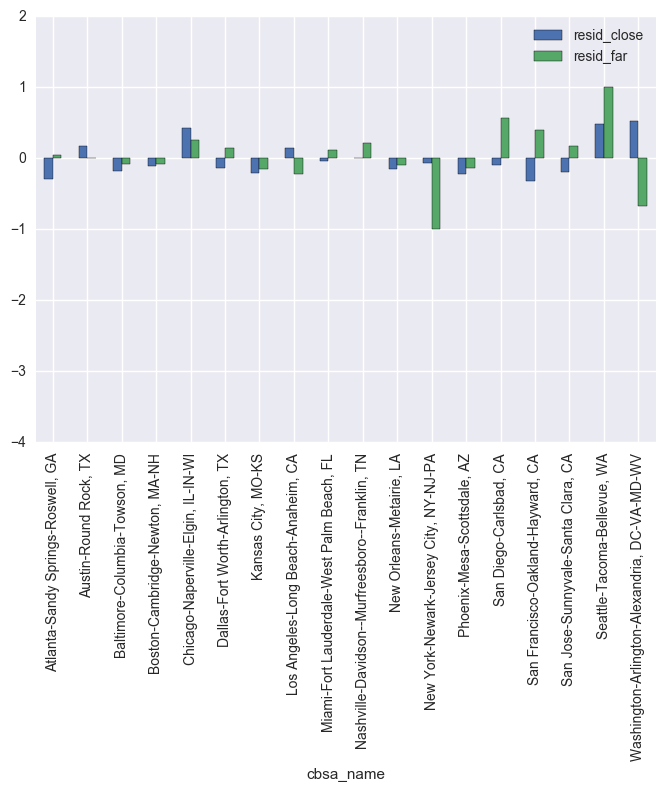

In [18]:
rel_close_far = (df_training.assign(dist_close = lambda x: x['dist_round'] <= 4)
                            .assign(resid_close = lambda x: (x['residuals'] / x['pop10']) * x['dist_close'],
                                    resid_far = lambda x: (x['residuals'] / x['pop10']) * (~x['dist_close']))
                            .groupby(level='cbsa_name').sum()[['resid_close', 'resid_far']])
rel_close_far.plot(kind='bar', ylim=(-4, 2))

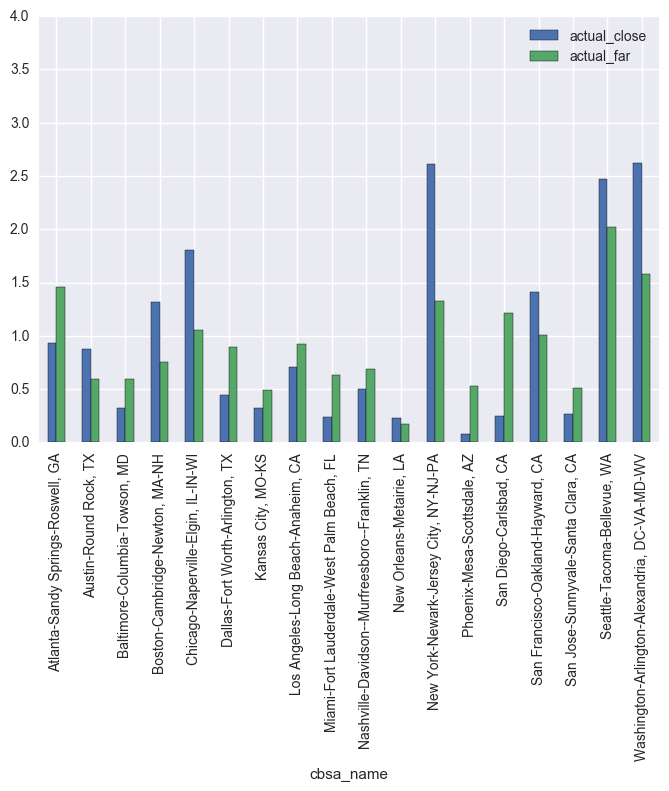

In [19]:
actual_close_far = (df_training.assign(dist_close = lambda x: x['dist_round'] <= 4)
                               .assign(actual_close = lambda x: (x['initial_customers'] / x['pop10']) * x['dist_close'],
                                       actual_far = lambda x: (x['initial_customers'] / x['pop10']) * (~x['dist_close']))
                               .groupby(level='cbsa_name').sum()[['actual_close', 'actual_far']])
actual_close_far.plot(kind='bar', ylim=(0, 4))

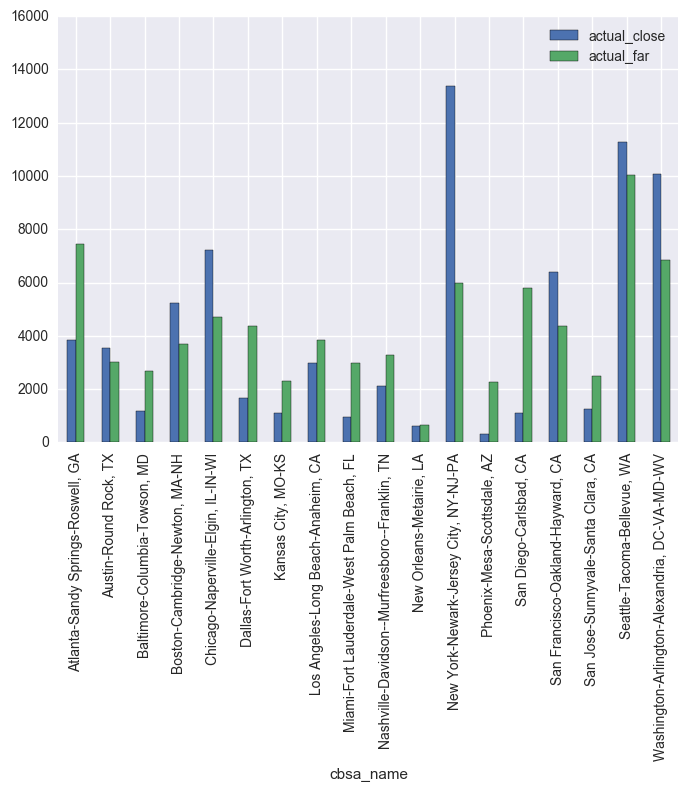

In [20]:
actual_close_far = (df_training.assign(dist_close = lambda x: x['dist_round'] <= 4)
                               .assign(actual_close = lambda x: x['initial_customers'] * x['dist_close'],
                                       actual_far = lambda x: x['initial_customers'] * (~x['dist_close']))
                               .groupby(level='cbsa_name').sum()[['actual_close', 'actual_far']])
actual_close_far.plot(kind='bar', ylim=(0, 16000))

In [ ]:
# Add store level LOOCV